# Assignment 2
## Stochastic and Spatial Models
---
Peterson, Victoria J  
*ID: 15476758* 

Beumer, Wessel T L
*ID: 12640662*

University of Amsterdam  
*Introduction to Computational Science, Block 1, 2024*  

Due: 27 October 2024

---

In [1]:
import numpy as np
from scipy.integrate import odeint 
from scipy import fftpack
import networkx as nx
import ndlib.models.epidemics as ep
import dataclasses
import matplotlib.pyplot as plt

In [2]:
# SIR Model Results Dataclass
@dataclasses.dataclass
class Results:
    S_List: list[int]
    I_List: list[int]
    R_List: list[int]
    time: list[float]

In [3]:
# Gillespies Algorithm Events for SIR Model
class Event:
    dX = 0.0
    dY = 0.0
    dZ = 0.0
    rate = 0.0

class Transmission(Event):
    def __init__(self, beta, X, Y, Z, N):
        self.dX = -1
        self.dY = 1
        self.dZ = 0
        self.rate = beta*X*Y/N

class Births(Event):
    def __init__(self, mu, X, Y, Z, N):
        self.dX = 1
        self.dY = 0
        self.dZ = 0
        self.rate = mu*N

class DeathsX(Event):
    def __init__(self, mu, X, Y, Z, N):
        self.dX = -1
        self.dY = 0.0
        self.dZ = 0.0
        self.rate = mu*X

class DeathsY(Event):
    def __init__(self, mu, X, Y, Z, N):
        self.dX = 0.0
        self.dY = -1
        self.dZ = 0.0
        self.rate = mu*Y

class DeathsZ(Event):
    def __init__(self, mu, X, Y, Z, N):
        self.dX = 0.0
        self.dY = 0.0
        self.dZ = -1
        self.rate = mu*Z

class Recovery(Event):
    def __init__(self, gamma, X, Y, Z, N):
        self.dX = 0.0
        self.dY = -1
        self.dZ = 1
        self.rate = gamma*Y

In [4]:
# SIR Model Gillespies Algorithm Class
class SIRModelGillespies:
    # Constructor
    def __init__ (self, 
                  X, Y, Z, N, 
                  beta, gamma, mu):
        
        self.X = X
        self.Y = Y
        self.Z = Z
        self.N = N
        self.beta = beta
        self.gamma = gamma
        self.mu = mu
        self.results = Results([], [], [], [])
        self.extinctionTime = float('inf')

    # Calculate Events for Gillespies Algorithm
    def calcEvents(self):
        events = []
        events.append(Transmission(self.beta, self.X, self.Y, self.Z, self.N))
        events.append(Births(self.mu, self.X, self.Y, self.Z, self.N))
        events.append(DeathsX(self.mu, self.X, self.Y, self.Z, self.N))
        events.append(DeathsY(self.mu, self.X, self.Y, self.Z, self.N))
        events.append(DeathsZ(self.mu, self.X, self.Y, self.Z, self.N))
        events.append(Recovery(self.gamma, self.X, self.Y, self.Z, self.N))
        return events

    # Gillespies Direct Algorithm
    def gillespiesAlgorithm(self):
        events = self.calcEvents()
        rateTotal = sum([i.rate for i in events])

        deltaT = -1/rateTotal * np.log(np.random.rand())

        probabilities = np.random.rand() * rateTotal

        upperRate = 0

        for i in events:
            lowerRate = upperRate
            upperRate += i.rate

            if lowerRate < probabilities <= upperRate:
                return i, deltaT
    
    # Gillespies First Reaction Algorithm
    def gillespiesFirstReaction(self):
        events = self.calcEvents()

        minimumDeltaT = float('inf')
        minimumEvent = None

        for i in events:
            if i.rate > 0:
                eventDeltaT = -1/i.rate * np.log(np.random.rand())
                if eventDeltaT < minimumDeltaT:
                    minimumDeltaT = eventDeltaT
                    minimumEvent = i

        return minimumEvent, minimumDeltaT
                
    # Gillespies Simulation using Gillespies Direct Algorithm
    def gillespiesSimulation(self, 
                             finalTime):
        time = 0

        while time < finalTime:
            event, deltaT = self.gillespiesAlgorithm()
            time += deltaT

            self.X += event.dX
            self.Y += event.dY
            self.Z += event.dZ

            self.results.S_List.append(self.X)
            self.results.I_List.append(self.Y)
            self.results.R_List.append(self.Z)
            self.results.time.append(time)

            if (self.Y == 0) & (self.extinctionTime == float('inf')):
                self.extinctionTime = time
    
    # Getters
    @property
    def getExtinctionTime(self):
        return self.extinctionTime

In [5]:
# Deterministic SIR Model Class
class SIRModelDeterministic:
    # Constructor
    def __init__ (self, 
                  X, Y, Z, N, 
                  beta, gamma, mu, 
                  timeInterval, timeFinal):
        self.X = X
        self.Y = Y
        self.Z = Z
        self.N = N
        self.beta = beta
        self.gamma = gamma
        self.mu = mu
        self.timeInterval = timeInterval
        self.timeFinal = timeFinal
        self.results = Results([], [], [], [])

    # Deterministic SIR Model using Euler's
    def SIRModel(self):
        timeSpan = np.linspace(0, self.timeInterval, self.timeFinal)

        S = np.zeros(self.timeFinal//self.timeInterval)
        I = np.zeros(self.timeFinal//self.timeInterval)
        R = np.zeros(self.timeFinal//self.timeInterval)

        S[0], I[0], R[0] = self.X, self.Y, self.Z
        self.results.time.append(0)

        for t in range(1, len(timeSpan)):
            self.results.time.append(t)

            dSdt = self.mu * (self.N - S[t-1]) - self.beta * S[t-1] * I[t-1] / self.N
            dIdt = self.beta * S[t-1] * I[t-1] / self.N - self.gamma * I[t-1] - self.mu * I[t-1]
            dRdt = self.gamma * I[t-1] - self.mu * R[t-1]

            S[t] = S[t-1] + self.timeInterval * dSdt
            I[t] = I[t-1] + self.timeInterval * dIdt
            R[t] = R[t-1] + self.timeInterval * dRdt


        self.results.S_List = S
        self.results.I_List = I
        self.results.R_List = R


## Model Calculations

In [6]:
# Function to calculate the mean, variance and standard deviation of a given data array
def statsCalculation(dataArray):
    mean = np.mean(dataArray)

    sumOfSquares = sum([(i - mean)**2 for i in dataArray])

    variance = sumOfSquares / len(dataArray)

    standardDeviation = np.sqrt(variance)

    return mean, variance, standardDeviation

In [7]:
# Function to calculate the covariance of two given data arrays
def covarianceCalculation(dataArrayA, 
                          dataArrayB):
    meanA = np.mean(dataArrayA)
    meanB = np.mean(dataArrayB)
    sampleSize = len(dataArrayA)

    sumProductVariances = sum([(dataArrayA[i] - meanA) * (dataArrayB[i] - meanB) for i in range(len(dataArrayA))])

    covariance = sumProductVariances / sampleSize

    return covariance

In [8]:
# Simulate a number of Gillespies SIR Models
def simulateNumGillespies(X0, Y0, Z0, N, 
                          beta, gamma, mu, 
                          time, 
                          numRuns):
    models = []
    totalCovarianceSI = 0.0
    totalMeans = [0.0, 0.0, 0.0]
    totalVariances = [0.0, 0.0, 0.0]
    totalStandardDeviations = [0.0, 0.0, 0.0]

    for i in range(numRuns): # Iterate through number of runs
        model = SIRModelGillespies(X0, Y0, Z0, N, 
                                   beta, gamma, mu) # Simulate Gillespies for current parameters
        model.gillespiesSimulation(time)

        # if (model.results.I_List[-1] != 0):
        models.append(model) # Append model to list of models

        # Calculate mean, variance, and standard deviation for each list
        meanS, varianceS, standardDeviationS = statsCalculation(model.results.S_List)
        meanI, varianceI, standardDeviationI = statsCalculation(model.results.I_List)
        meanR, varianceR, standardDeviationR = statsCalculation(model.results.R_List)

        # Calculate covariance of SI
        totalCovarianceSI += covarianceCalculation(model.results.S_List, model.results.I_List)

        # Create SIR Arrays for each statistic
        means = [meanS, meanI, meanR]
        variances = [varianceS, varianceI, varianceR]
        standardDeviations = [standardDeviationS, standardDeviationI, standardDeviationR]

        # Adds the means, variances, and standard deviations of the current run to the totalRuns
        totalMeans = [i + j for i, j in zip(totalMeans, means)]
        totalVariances = [i + j for i, j in zip(totalVariances, variances)]
        totalStandardDeviations = [i + j for i, j in zip(totalStandardDeviations, standardDeviations)]
    
    return models, totalMeans, totalVariances, totalStandardDeviations, totalCovarianceSI # Returns the sum of the means, variances, and standard deviations of all runs
    

## Plotting Functions

In [9]:
def plotStatisticsSIR(deterministicStat,
                      stochasticStat, 
                      parameterValues, 
                      title, xlabel, ylabel):
    stdDevS = [stochasticStat[b][0] for b in parameterValues]
    stdDevI = [stochasticStat[b][1] for b in parameterValues]
    stdDevR = [stochasticStat[b][2] for b in parameterValues]

    dStdDevS = [deterministicStat[b][0] for b in parameterValues]
    dStdDevI = [deterministicStat[b][1] for b in parameterValues]
    dStdDevR = [deterministicStat[b][2] for b in parameterValues]

    plt.figure()

    plt.plot(parameterValues, stdDevS, 'r', label = "S")
    plt.plot(parameterValues, stdDevI, 'b', label = "I")
    plt.plot(parameterValues, stdDevR, 'g', label = "R")

    plt.plot(parameterValues, dStdDevS, 'r--', label = "S Deterministic")
    plt.plot(parameterValues, dStdDevI, 'b--', label = "I Deterministic")
    plt.plot(parameterValues, dStdDevR, 'g--', label = "R Deterministic")

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()

    plt.show()

In [10]:
def plotSIRSimulations(deterministicModel, 
                       stochasticModels, 
                       parameterValue, 
                       title, xlabel, ylabel):
    plt.figure()

    for i in range(len(stochasticModels[parameterValue])):
        plt.plot(stochasticModels[parameterValue][i].results.time, stochasticModels[parameterValue][i].results.S_List, alpha=0.1, color = 'grey')
        plt.plot(stochasticModels[parameterValue][i].results.time, stochasticModels[parameterValue][i].results.I_List, alpha=0.1, color = 'grey')
        plt.plot(stochasticModels[parameterValue][i].results.time, stochasticModels[parameterValue][i].results.R_List, alpha=0.1, color = 'grey')

    plt.plot(deterministicModel[parameterValue].results.time, deterministicModel[parameterValue].results.S_List, 'r')
    plt.plot(deterministicModel[parameterValue].results.time, deterministicModel[parameterValue].results.I_List, 'b')
    plt.plot(deterministicModel[parameterValue].results.time, deterministicModel[parameterValue].results.R_List, 'g')

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    plt.show()

In [11]:
def plotCovarianceSI(dCovarianceSI, 
                     covarianceSI, 
                     parameterValuesRange, 
                     title, xlabel, ylabel):
    covarianceValuesGammaSI = [covarianceSI[g] for g in parameterValuesRange]
    dCovarianceValuesSI = [dCovarianceSI[g] for g in parameterValuesRange]

    plt.figure()

    plt.plot(parameterValuesRange, covarianceValuesGammaSI, 'r', label = "SI Covariance")
    plt.plot(parameterValuesRange, dCovarianceValuesSI, 'r--', label = "SI Covariance Deterministic")

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()

    plt.show()

In [196]:
def plot3DMeshBetaGamma(parameterValuesA, 
                        parameterValuesB, 
                        z_values, 
                        xlabel, ylabel, zlabel, title, 
                        elev=40, azim=50):
    npParameterValuesA = np.array(parameterValuesA)
    npParameterValuesB = np.array(parameterValuesB)
    npZValues = np.array(z_values)

    parameterUniqueA = np.unique(npParameterValuesA)
    parameterUniqueB = np.unique(npParameterValuesB)
    
    parameterMeshA, parameterMeshB = np.meshgrid(parameterUniqueA, parameterUniqueB)

    zMesh = npZValues.reshape(len(parameterUniqueB), len(parameterUniqueA))

    fig = plt.figure(figsize=(15, 15))
    plot3D = fig.add_subplot(111, projection='3d')

    plotMesh = plot3D.plot_surface(parameterMeshA, parameterMeshB, zMesh, cmap='viridis')

    plot3D.set_xlabel(xlabel)
    plot3D.set_ylabel(ylabel)
    plot3D.set_zlabel(zlabel)
    plot3D.set_title(title)
    plot3D.view_init(elev=elev, azim=azim)

    fig.colorbar(plotMesh, ax=plot3D, shrink=0.5, aspect=20)

    # Show plot
    plt.show()

In [55]:
def calcExtinctionMetrics2D(parameterValues, 
                            allModels, 
                            time):
    averageExtinctionTime = {} # Dictionary to store the average extinction time for each parameter value
    proportionExtinctions = {} # Dictionary to store the proportion of extinctions for each parameter value

    # Iterate through all parameter values
    for p in parameterValues: 
        numExtinctions = 0 # Counter for the number of extinctions
        totalExtinctionTime = 0 # Counter for the total extinction time

        # Iterate through all models for the current parameter value
        for m in allModels[p]: 
            extinctionTime = m.getExtinctionTime # Get the extinction time for the current model
            
            # Removes models that did not go extinct
            if extinctionTime < time: 
                numExtinctions += 1 # Increment the number of extinctions
                totalExtinctionTime += extinctionTime # Add the extinction time to the total extinction time
            
            # Calculate the average extinction time and proportion of extinctions for the current tuple of parameter values
            if numExtinctions > 0: 
                averageExtinctionTime[p] = totalExtinctionTime / numExtinctions
            else:
                averageExtinctionTime[p] = None  # If no extinctions occur, set average extinction time to maximum

        proportionExtinctions[p] = numExtinctions / len(allModels[p]) # Calculate the proportion of extinctions for the current parameter value
    
    return averageExtinctionTime, proportionExtinctions 

In [56]:
def calcExtinctionMetrics3D(parameterValuesA, 
                            parameterValuesB, 
                            allModels, 
                            time):
    averageExtinctionTime = {} # Dictionary to store the average extinction time for each tuple of parameter values
    proportionExtinctions = {} # Dictionary to store the proportion of extinctions for each tuple of parameter values

    # Iterate through all parameter values
    for a in parameterValuesA:
        for b in parameterValuesB:
            numExtinctions = 0
            totalExtinctionTime = 0 

            # Iterate through all models for the current tuple of parameter values
            for m in allModels[a, b]: 
                extinctionTime = m.getExtinctionTime # Get the extinction time for the current model

                # Removes models that did not go extinct
                if extinctionTime < time: 
                    numExtinctions += 1 
                    totalExtinctionTime += extinctionTime 

            # Calculate the average extinction time and proportion of extinctions for the current tuple of parameter values
            if numExtinctions > 0: 
                averageExtinctionTime[a, b] = totalExtinctionTime / numExtinctions
            else:
                averageExtinctionTime[a, b] = None  # If no extinctions occur, set average extinction time to maximum
            
            # Calculate the proportion of extinctions for the current tuple of parameter values
            proportionExtinctions[a, b] = numExtinctions / len(allModels[a, b])
    
    return averageExtinctionTime, proportionExtinctions

## Statistical Features of a Range of Infection Rates Beta

In [15]:
X0 = 999
Y0 = 1
Z0 = 0
N = X0 + Y0 + Z0
beta = 0.5
gamma = 0.1
mu = 0.01

time = 100
timeInterval = 1

In [16]:
numRuns = 50

betaMax = 1
betaSteps = 40
betaMin = betaMax / betaSteps
betaValues = np.linspace(betaMin, betaMax, betaSteps)

In [17]:
allModelsBeta = {}
variancesBeta = {}
meansBeta = {}
standardDeviationsBeta = {}
covarianceBeta = {}

for b in betaValues:
    # Simulate Gillespies for current beta value
    modelsBeta, totalMeans, totalVariances, totalStandardDeviations, totalCovarianceSI = simulateNumGillespies(X0, Y0, Z0, N, 
                                                                                                               b, 
                                                                                                               gamma, mu, 
                                                                                                               time, 
                                                                                                               numRuns)

    # Calculates the average of all runs for each statistic. This gives the average of the statistic for a specific beta value
    meansBeta[b] = [i/numRuns for i in totalMeans]
    variancesBeta[b] = [i/numRuns for i in totalVariances]
    standardDeviationsBeta[b] = [i/numRuns for i in totalStandardDeviations]
    covarianceBeta[b] = totalCovarianceSI / numRuns

    # Adds the models to the dictionary of models for each beta value
    allModelsBeta[b] = modelsBeta

In [18]:
dAllModelsBeta = {}
dMeansBeta = {}
dVariancesBeta = {}
dStandardDeviationsBeta = {}
dCovarianceSI = {}

# Simulate Deterministic SIR Model for range of Beta
for b in betaValues:
    deterministicModel = SIRModelDeterministic(X0, Y0, Z0, N, 
                                               b, 
                                               gamma, mu, 
                                               timeInterval, time)
    deterministicModel.SIRModel()

    dMeanS, dVarianceS, dStandardDeviationS = statsCalculation(deterministicModel.results.S_List)
    dMeanI, dVarianceI, dStandardDeviationI = statsCalculation(deterministicModel.results.I_List)
    dMeanR, dVarianceR, dStandardDeviationR = statsCalculation(deterministicModel.results.R_List)

    dCovarianceSI[b] = covarianceCalculation(deterministicModel.results.S_List, deterministicModel.results.I_List)

    dMeans = [dMeanS, dMeanI, dMeanR]
    dVariances = [dVarianceS, dVarianceI, dVarianceR]
    dStandardDeviations = [dStandardDeviationS, dStandardDeviationI, dStandardDeviationR]

    dMeansBeta[b] = dMeans
    dVariancesBeta[b] = dVariances
    dStandardDeviationsBeta[b] = dStandardDeviations

    dAllModelsBeta[b] = deterministicModel

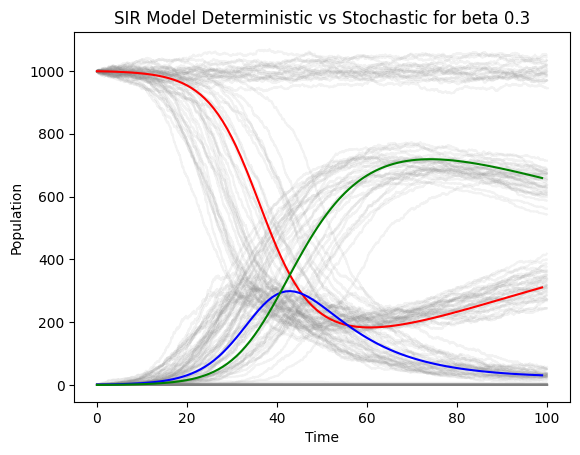

In [19]:
testBeta = 0.3
plotSIRSimulations(dAllModelsBeta, 
                   allModelsBeta, 
                   testBeta, 
                   "SIR Model Deterministic vs Stochastic for beta 0.3", 
                   "Time", 
                   "Population")

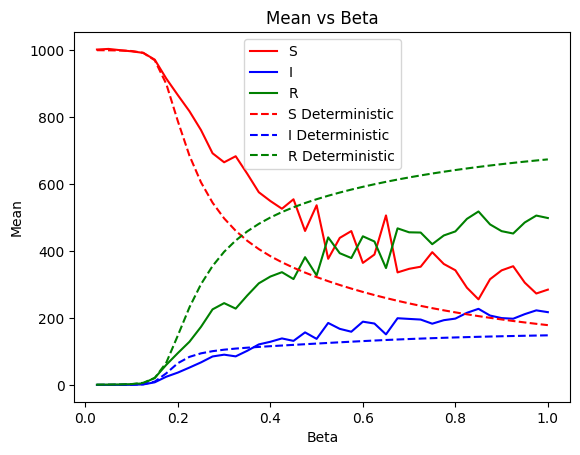

In [20]:
plotStatisticsSIR(dMeansBeta, 
                  meansBeta, 
                  betaValues, 
                  "Mean vs Beta", 
                  "Beta", 
                  "Mean")

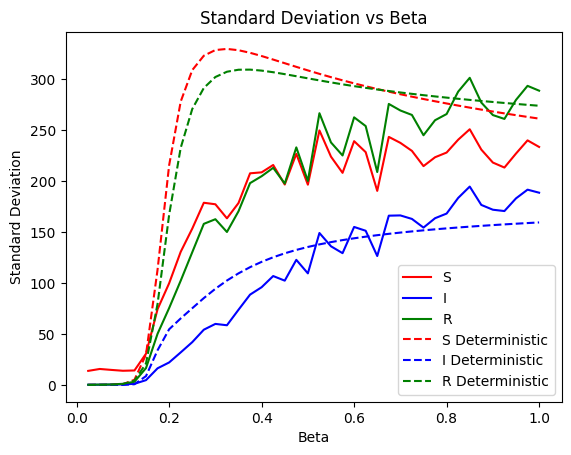

In [21]:
plotStatisticsSIR(dStandardDeviationsBeta, 
                  standardDeviationsBeta, 
                  betaValues, 
                  "Standard Deviation vs Beta", 
                  "Beta", 
                  "Standard Deviation")

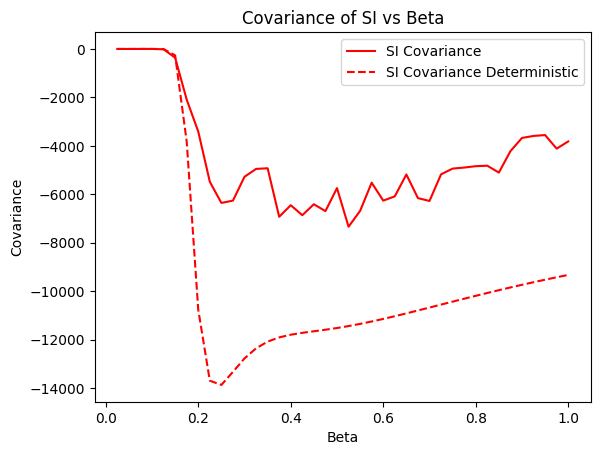

In [22]:
plotCovarianceSI(dCovarianceSI, 
                 covarianceBeta, 
                 betaValues, 
                 "Covariance of SI vs Beta", 
                 "Beta", 
                 "Covariance")

## Statistical Features of a Range of Recovery Rates Gamma

In [23]:
X0 = 999
Y0 = 1
Z0 = 0
N = X0 + Y0 + Z0
beta = 0.5
gamma = 0.1
mu = 0.01

time = 250
timeInterval = 1

In [24]:
numRuns = 50
gammaMax = 0.5
gammaSteps = 40
gammaMin = gammaMax / gammaSteps
gammaValues = np.linspace(gammaMin, gammaMax, gammaSteps)

In [25]:
allModelsGamma = {}
variancesGamma = {}
meansGamma = {}
standardDeviationsGamma = {}
covarianceGammaSI = {}

for g in gammaValues:
    modelsGamma, totalMeans, totalVariances, totalStandardDeviations, covarianceSI = simulateNumGillespies(X0, Y0, Z0, N, 
                                                                                                           beta, 
                                                                                                           g, 
                                                                                                           mu, 
                                                                                                           time, 
                                                                                                           numRuns)

    meansGamma[g] = [i/numRuns for i in totalMeans]
    variancesGamma[g] = [i/numRuns for i in totalVariances]
    standardDeviationsGamma[g] = [i/numRuns for i in totalStandardDeviations]
    covarianceGammaSI[g] = covarianceSI / numRuns

    allModelsGamma[g] = modelsGamma

In [26]:
dAllModelsGamma = {}
dMeansGamma = {}
dVariancesGamma = {}
dStandardDeviationsGamma = {}
dCovarianceGammaSI = {}

for g in gammaValues:
    deterministicModel = SIRModelDeterministic(X0, Y0, Z0, N, 
                                               beta, 
                                               g, 
                                               mu, 
                                               timeInterval, 
                                               time)
    deterministicModel.SIRModel()

    dMeanS, dVarianceS, dStandardDeviationS = statsCalculation(deterministicModel.results.S_List)
    dMeanI, dVarianceI, dStandardDeviationI = statsCalculation(deterministicModel.results.I_List)
    dMeanR, dVarianceR, dStandardDeviationR = statsCalculation(deterministicModel.results.R_List)

    dCovarianceGammaSI[g] = covarianceCalculation(deterministicModel.results.S_List, deterministicModel.results.I_List)

    dMeansGamma[g] = [dMeanS, dMeanI, dMeanR]
    dVariancesGamma[g] = [dVarianceS, dVarianceI, dVarianceR]
    dStandardDeviationsGamma[g] = [dStandardDeviationS, dStandardDeviationI, dStandardDeviationR]

    dAllModelsGamma[g] = deterministicModel

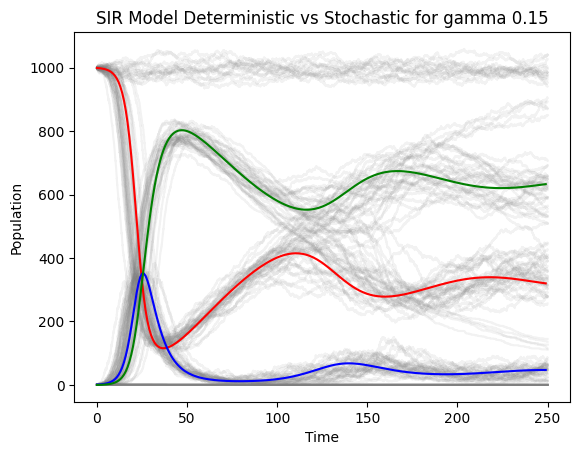

In [27]:
testGamma = 0.15
plotSIRSimulations(dAllModelsGamma, 
                   allModelsGamma, 
                   testGamma, 
                   "SIR Model Deterministic vs Stochastic for gamma 0.15", 
                   "Time", 
                   "Population")

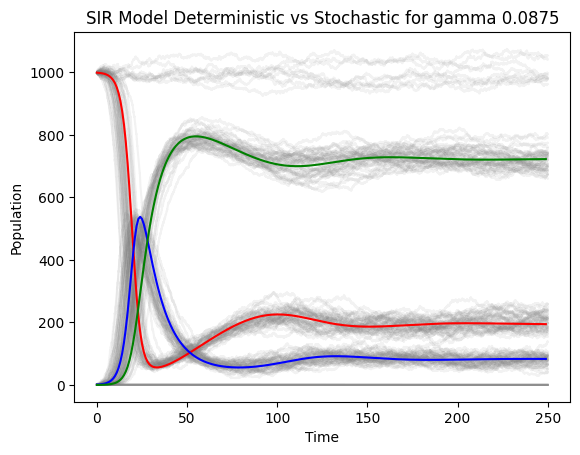

In [28]:
testGamma = 0.0875
plotSIRSimulations(dAllModelsGamma, 
                   allModelsGamma, 
                   testGamma, 
                   "SIR Model Deterministic vs Stochastic for gamma 0.0875", 
                   "Time", 
                   "Population")

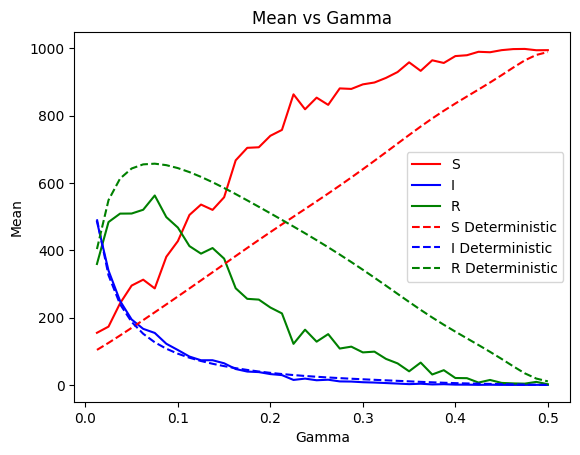

In [29]:
plotStatisticsSIR(dMeansGamma, 
                  meansGamma, 
                  gammaValues, 
                  "Mean vs Gamma", 
                  "Gamma", 
                  "Mean")

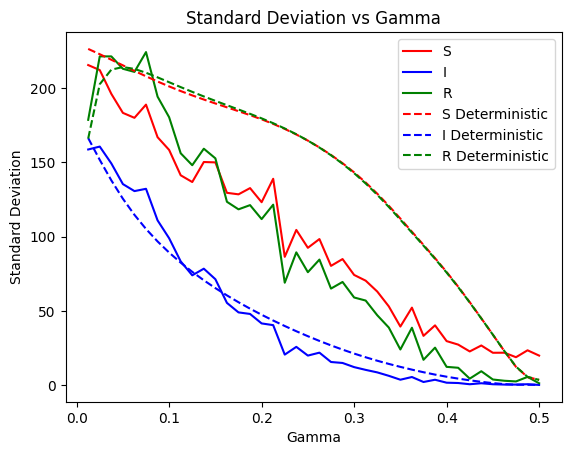

In [30]:
plotStatisticsSIR(dStandardDeviationsGamma, 
                  standardDeviationsGamma, 
                  gammaValues, 
                  "Standard Deviation vs Gamma", 
                  "Gamma", 
                  "Standard Deviation")

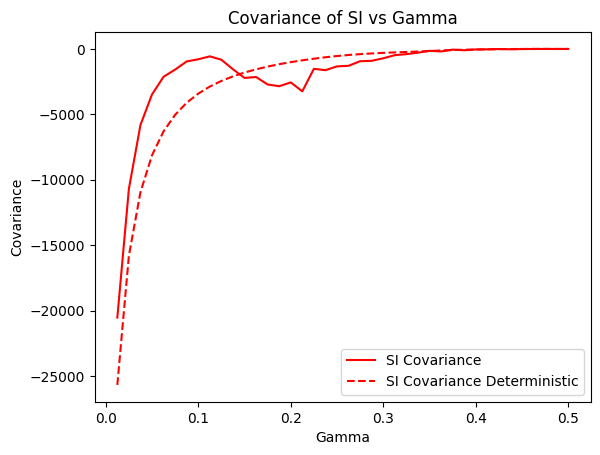

In [31]:
plotCovarianceSI(dCovarianceGammaSI, 
                 covarianceGammaSI, 
                 gammaValues, 
                 "Covariance of SI vs Gamma", 
                 "Gamma", 
                 "Covariance")

# Statistical Features of a Range of Gamma, Beta Values

In [88]:
X0 = 999
Y0 = 1
Z0 = 0
N = X0 + Y0 + Z0
beta = 0.5
gamma = 0.1
mu = 0.01

time = 100
timeInterval = 1

In [89]:
numRuns = 25

gamma3DMax = 0.6 #1.0
gamma3DSteps = 20
gamma3DMin = gamma3DMax / gamma3DSteps
gamma3DValues = np.linspace(gamma3DMin, gamma3DMax, gamma3DSteps)

beta3DMax = 1.0
beta3DSteps = 20
beta3DMin = beta3DMax / beta3DSteps
beta3DValues = np.linspace(beta3DMin, beta3DMax, beta3DSteps)

In [90]:
allModelsBetaGamma = {}
variancesBetaGamma = {}
meansBetaGamma = {}
standardDeviationsBetaGamma = {}
covarianceBetaGammaSI = {}

for b in beta3DValues:
    for g in gamma3DValues:
        modelsBetaGamma, totalMeans, totalVariances, totalStandardDeviations, covarianceSI = simulateNumGillespies(X0, Y0, Z0, N, 
                                                                                                                   b, g, 
                                                                                                                   mu, 
                                                                                                                   time, 
                                                                                                                   numRuns)

        meansBetaGamma[b, g] = [i/numRuns for i in totalMeans]
        variancesBetaGamma[b, g] = [i/numRuns for i in totalVariances]
        standardDeviationsBetaGamma[b, g] = [i/numRuns for i in totalStandardDeviations]
        covarianceBetaGammaSI[b, g] = covarianceSI / numRuns

        allModelsBetaGamma[b, g] = modelsBetaGamma

In [169]:
r0Values = []
stdDevSValues = []
stdDevIValues = []
stdDevRValues = []

covarianceValuesSI = []

for g in gamma3DValues:
    for b in beta3DValues:
        r0 = b / (g+mu)
        r0Values.append(r0)

        stdS, stdI, stdR = standardDeviationsBetaGamma[b, g]

        stdDevSValues.append(stdS)
        stdDevIValues.append(stdI)
        stdDevRValues.append(stdR)

        covarianceValuesSI.append(covarianceBetaGammaSI[b, g])

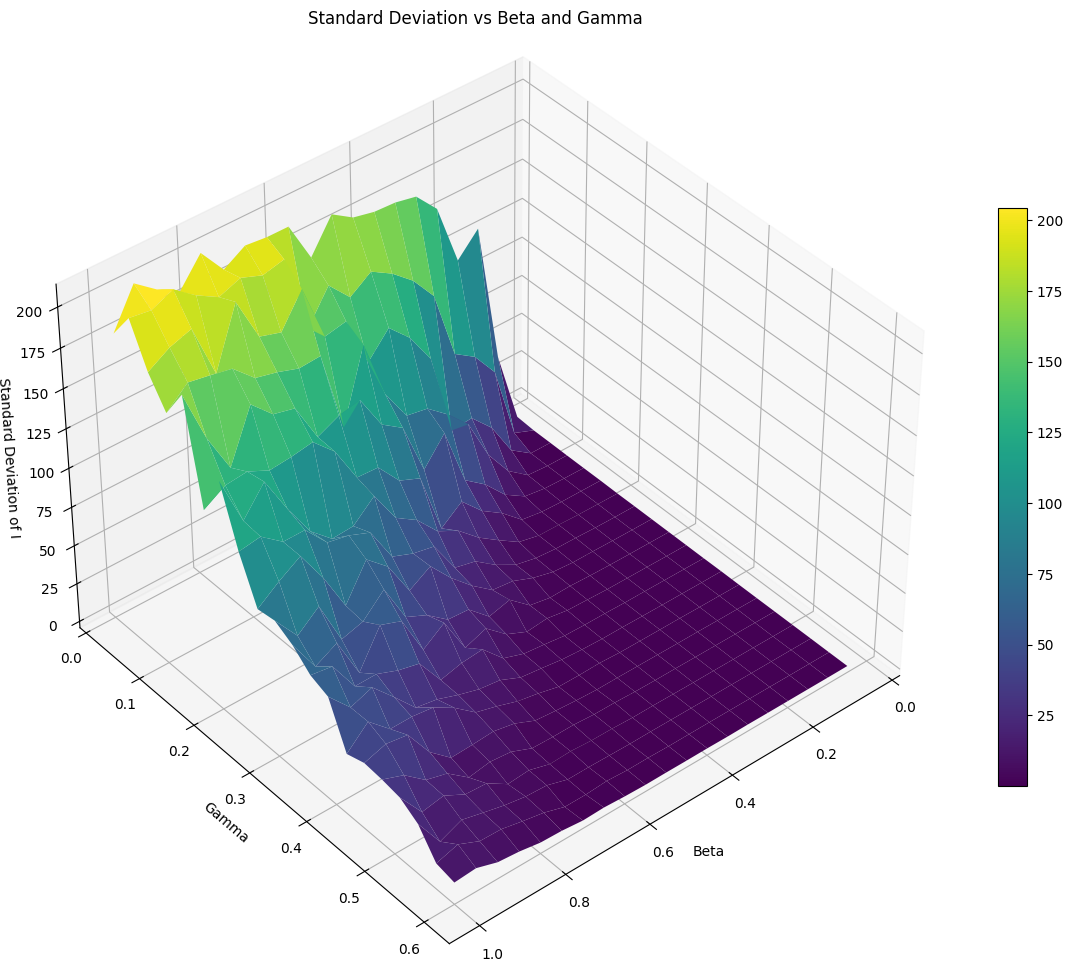

In [197]:
plot3DMeshBetaGamma(beta3DValues,
                    gamma3DValues,
                    stdDevIValues, 
                    "Beta", 
                    "Gamma", 
                    "Standard Deviation of I", 
                    "Standard Deviation vs Beta and Gamma")

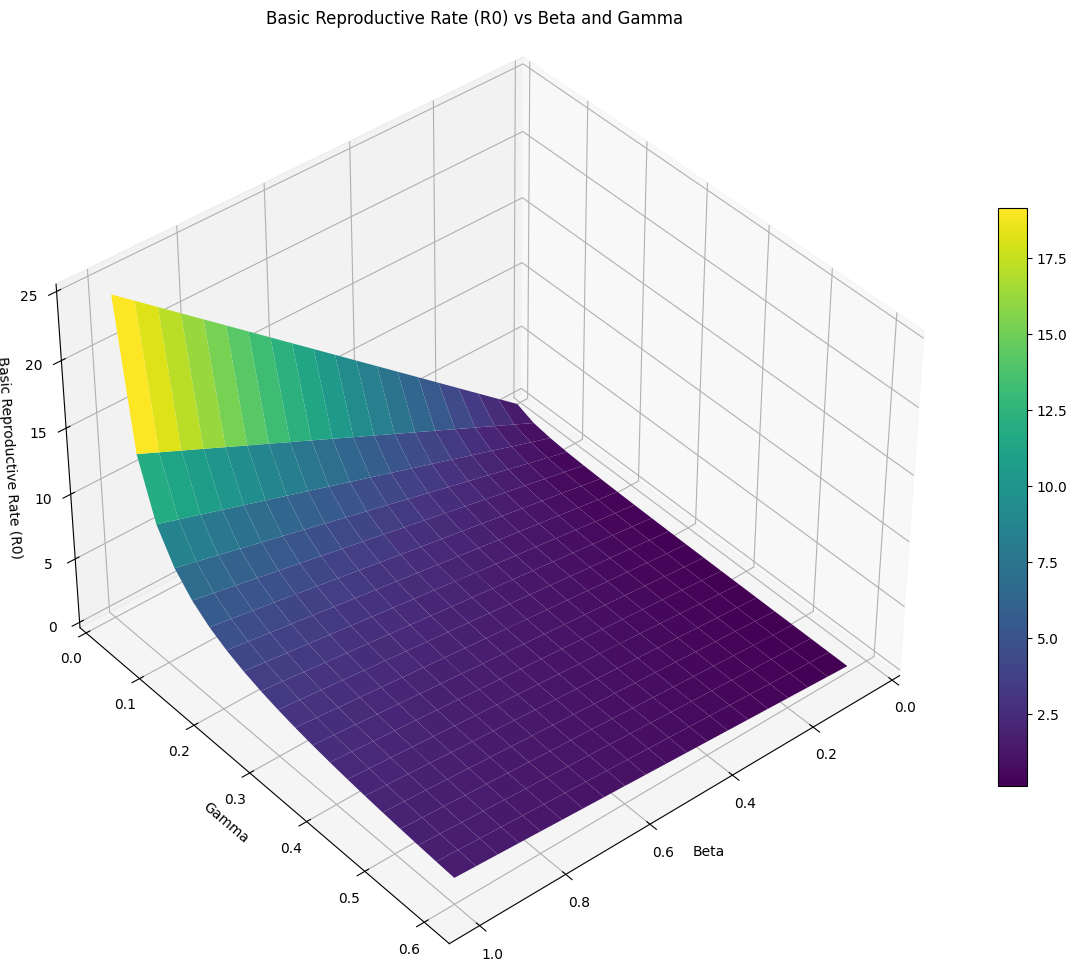

In [198]:
plot3DMeshBetaGamma(beta3DValues,
                    gamma3DValues, 
                    r0Values, 
                    "Beta", 
                    "Gamma", 
                    "Basic Reproductive Rate (R0)", 
                    "Basic Reproductive Rate (R0) vs Beta and Gamma")

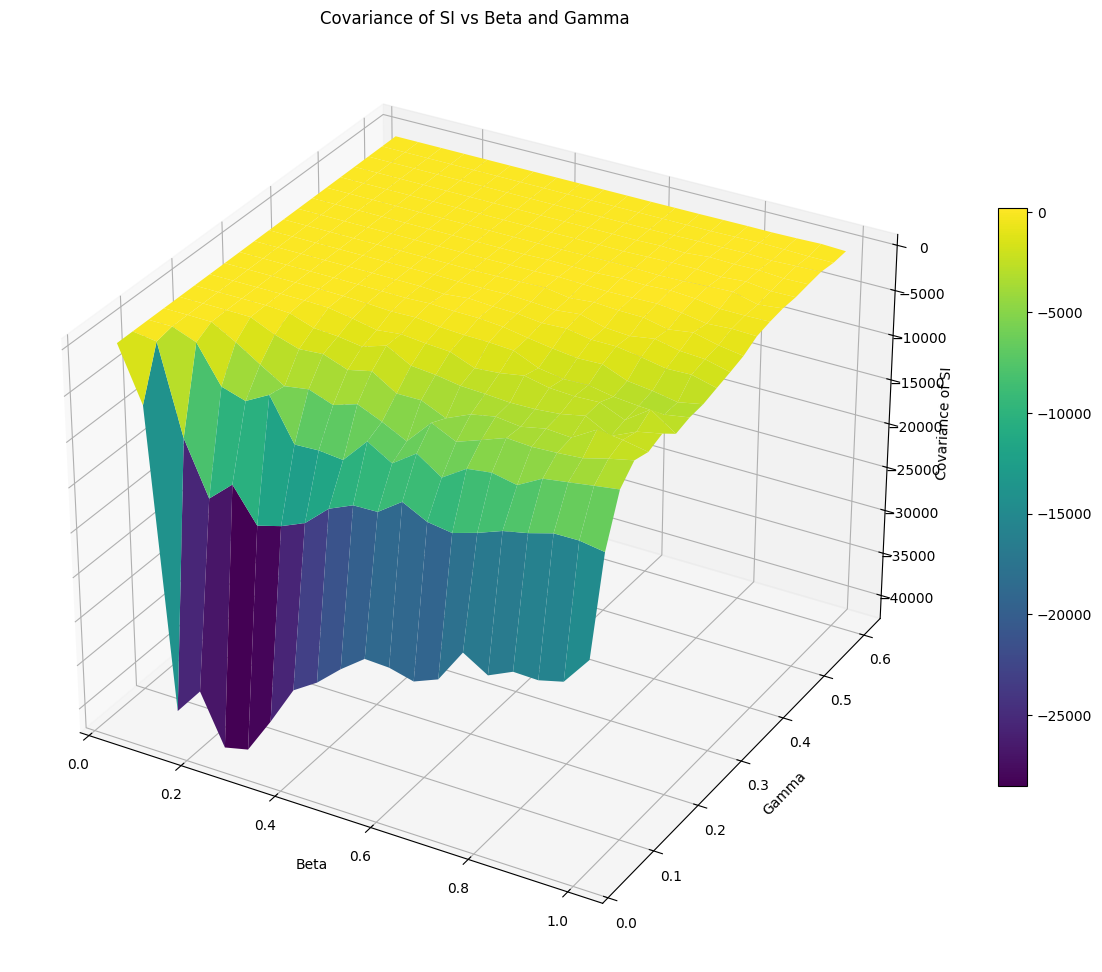

In [208]:
plot3DMeshBetaGamma(beta3DValues,
                    gamma3DValues,
                    covarianceValuesSI, 
                    "Beta", 
                    "Gamma", 
                    "Covariance of SI", 
                    "Covariance of SI vs Beta and Gamma", 
                    30, 300)

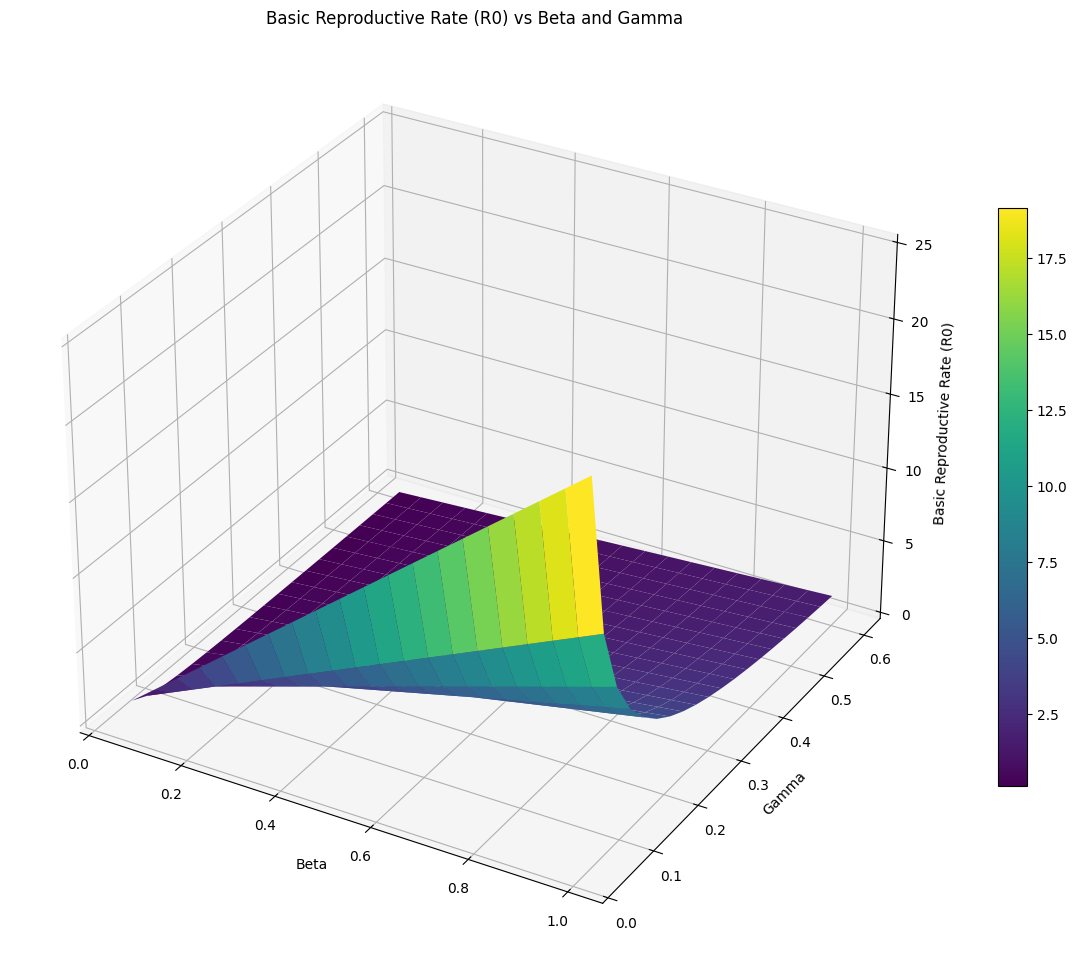

In [207]:
plot3DMeshBetaGamma(beta3DValues,
                    gamma3DValues, 
                    r0Values, 
                    "Beta", 
                    "Gamma", 
                    "Basic Reproductive Rate (R0)", 
                    "Basic Reproductive Rate (R0) vs Beta and Gamma",
                    30, 300)

## Extinction

In [94]:
averageExtinctionTimePerBeta = {}
averageExtinctionTimePerGamma = {}
averageExtinctionTimePerBetaGamma = {}  

proportionExtinctionsPerBeta = {}
proportionExtinctionsPerGamma = {}
proportionExtinctionsPerBetaGamma = {}

averageExtinctionTimePerBeta, proportionExtinctionsPerBeta = calcExtinctionMetrics2D(betaValues, 
                                                                                     allModelsBeta, 
                                                                                     time)

averageExtinctionTimePerGamma, proportionExtinctionsPerGamma = calcExtinctionMetrics2D(gammaValues, 
                                                                                       allModelsGamma, 
                                                                                       time)

averageExtinctionTimePerBetaGamma, proportionExtinctionsPerBetaGamma = calcExtinctionMetrics3D(beta3DValues, 
                                                                                               gamma3DValues, 
                                                                                               allModelsBetaGamma, 
                                                                                               time)

In [156]:
r0Values = []

for g in gamma3DValues:
    for b in beta3DValues:
        r0 = b / (g+mu)
        r0Values.append(r0)

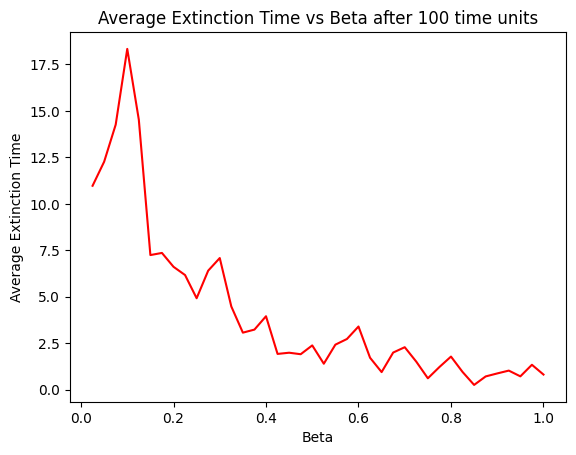

In [157]:
plt.figure()

plt.plot(averageExtinctionTimePerBeta.keys(), averageExtinctionTimePerBeta.values(), 'r')

plt.xlabel("Beta")
plt.ylabel("Average Extinction Time")
plt.title("Average Extinction Time vs Beta after 100 time units")

plt.show()

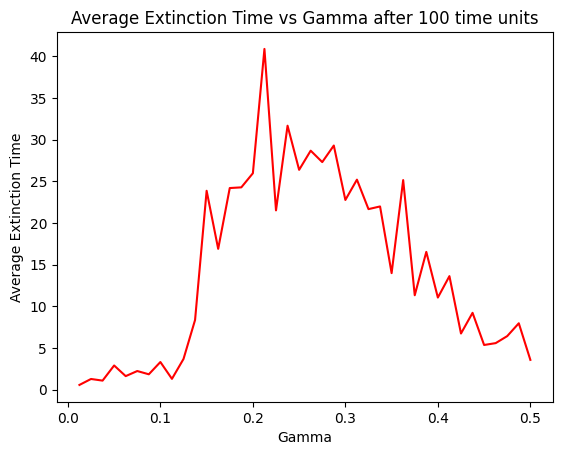

In [158]:
plt.figure()

plt.plot(averageExtinctionTimePerGamma.keys(), averageExtinctionTimePerGamma.values(), 'r')

plt.xlabel("Gamma")
plt.ylabel("Average Extinction Time")
plt.title("Average Extinction Time vs Gamma after 100 time units")

plt.show()

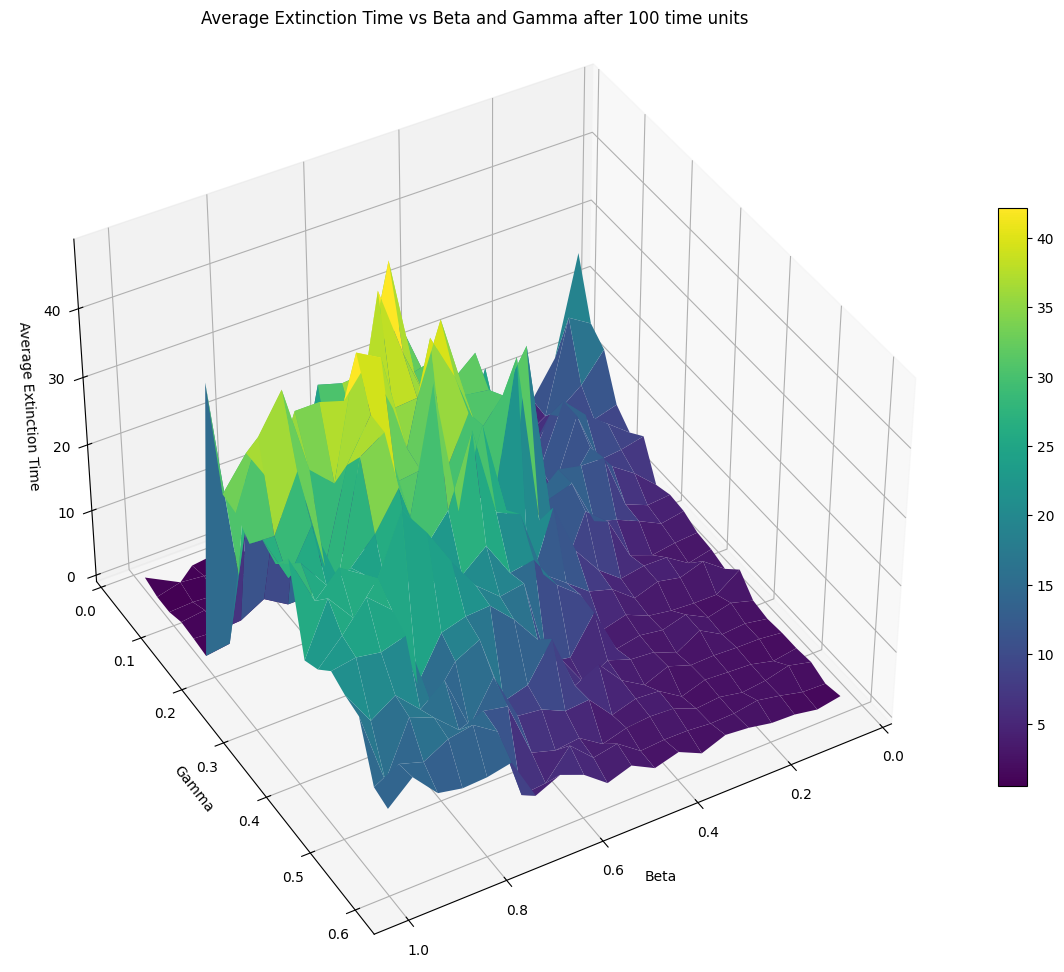

In [209]:
averageExtinctionTimePerBetaGammaArray = [averageExtinctionTimePerBetaGamma[b, g] for g in gamma3DValues for b in beta3DValues]

plot3DMeshBetaGamma(beta3DValues, 
                    gamma3DValues,
                    averageExtinctionTimePerBetaGammaArray, 
                    "Beta", 
                    "Gamma", 
                    "Average Extinction Time", 
                    "Average Extinction Time vs Beta and Gamma after 100 time units", 
                    40, 60)


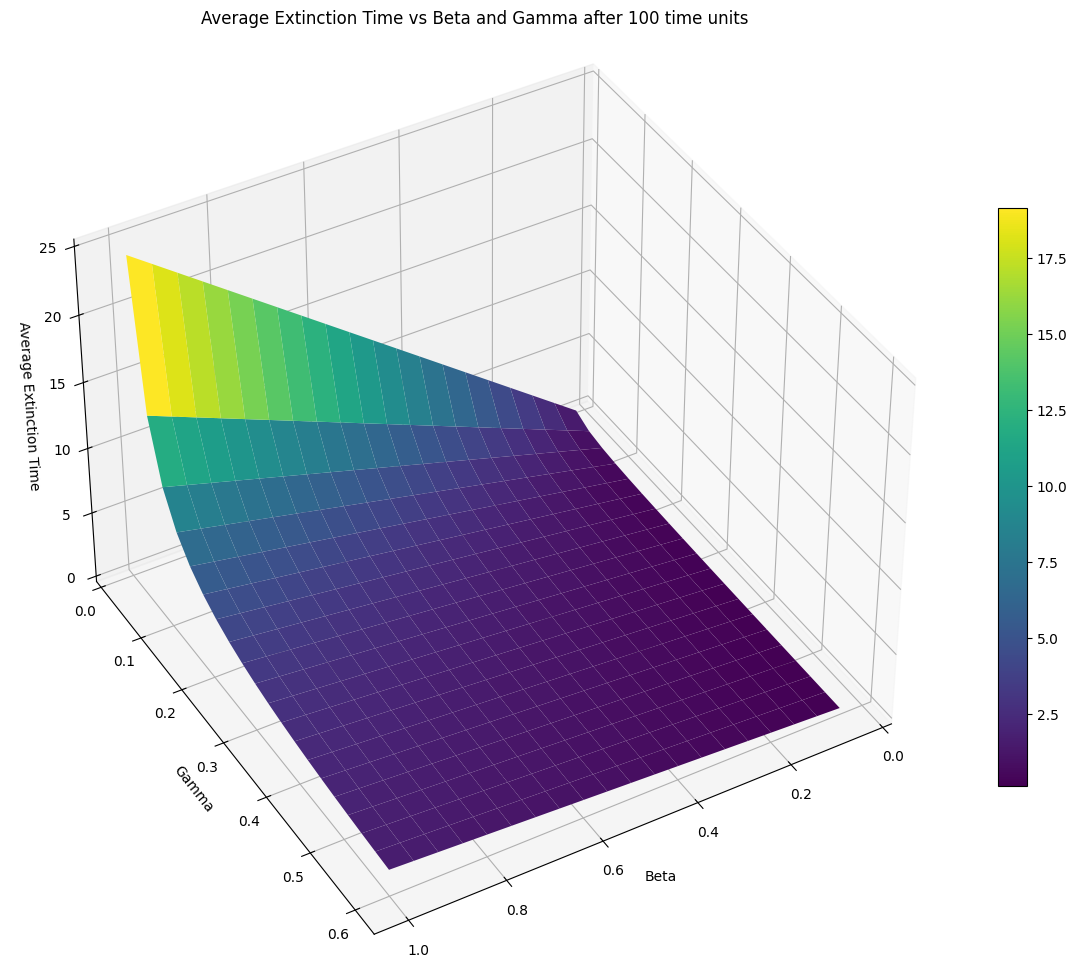

In [210]:
plot3DMeshBetaGamma(beta3DValues, 
                    gamma3DValues,
                    r0Values, 
                    "Beta", 
                    "Gamma", 
                    "Average Extinction Time", "Average Extinction Time vs Beta and Gamma after 100 time units", 
                    40, 60)

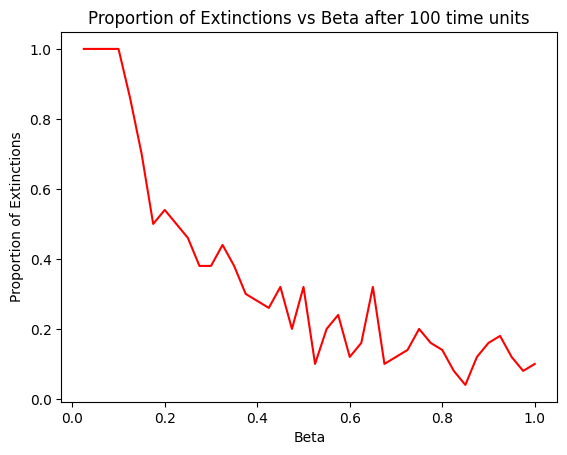

In [161]:
plt.figure()

plt.plot(proportionExtinctionsPerBeta.keys(), proportionExtinctionsPerBeta.values(), 'r')

plt.xlabel("Beta")
plt.ylabel("Proportion of Extinctions")
plt.title("Proportion of Extinctions vs Beta after 100 time units")

plt.show()

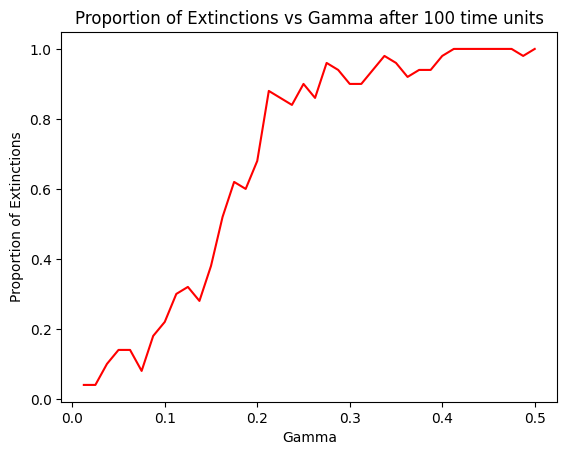

In [162]:
plt.figure()

plt.plot(proportionExtinctionsPerGamma.keys(), proportionExtinctionsPerGamma.values(), 'r')

plt.xlabel("Gamma")
plt.ylabel("Proportion of Extinctions")
plt.title("Proportion of Extinctions vs Gamma after 100 time units")

plt.show()

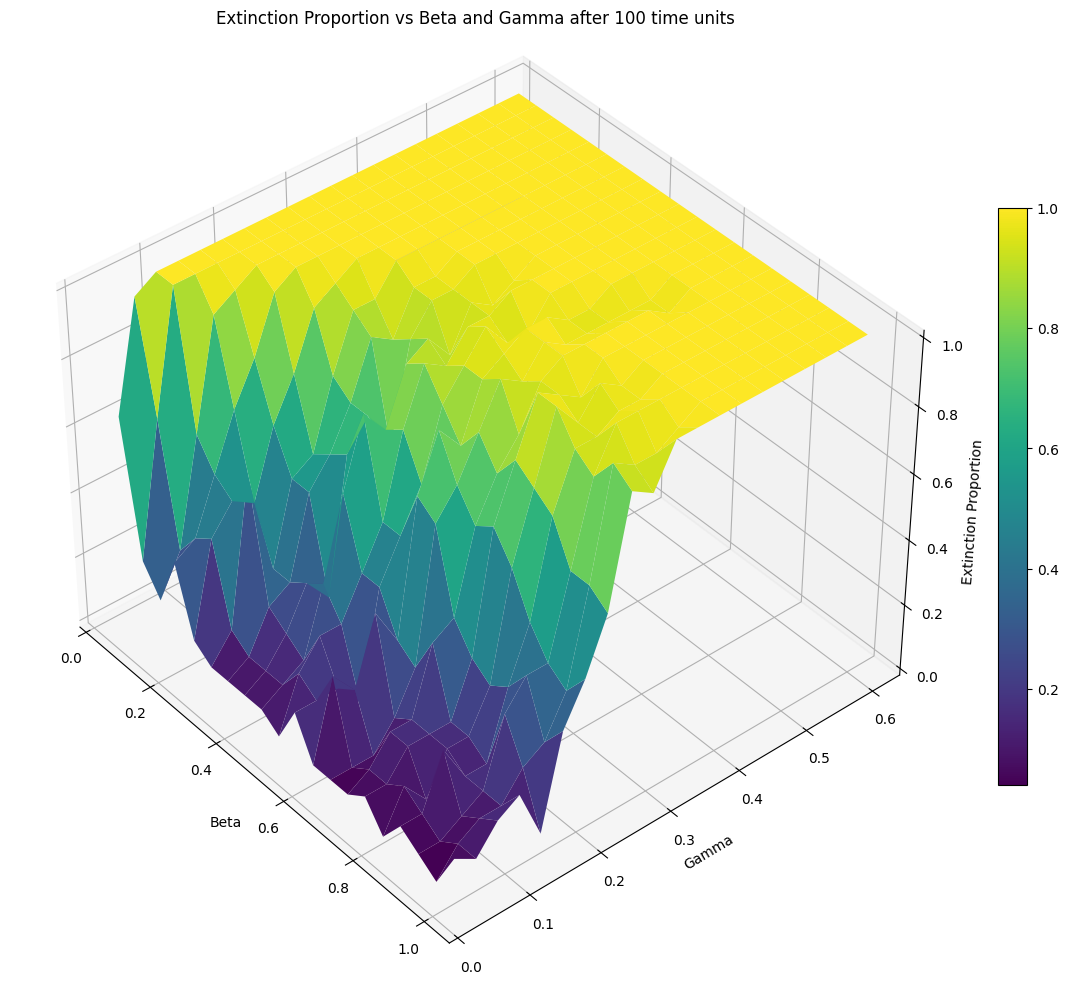

In [211]:
extinctionProportionPerBetaGammaArray = [proportionExtinctionsPerBetaGamma[b, g] for g in gamma3DValues for b in beta3DValues]

plot3DMeshBetaGamma(beta3DValues,
                    gamma3DValues, 
                    extinctionProportionPerBetaGammaArray, 
                    "Beta", 
                    "Gamma", 
                    "Extinction Proportion", 
                    "Extinction Proportion vs Beta and Gamma after 100 time units", 
                    40, 
                    320)

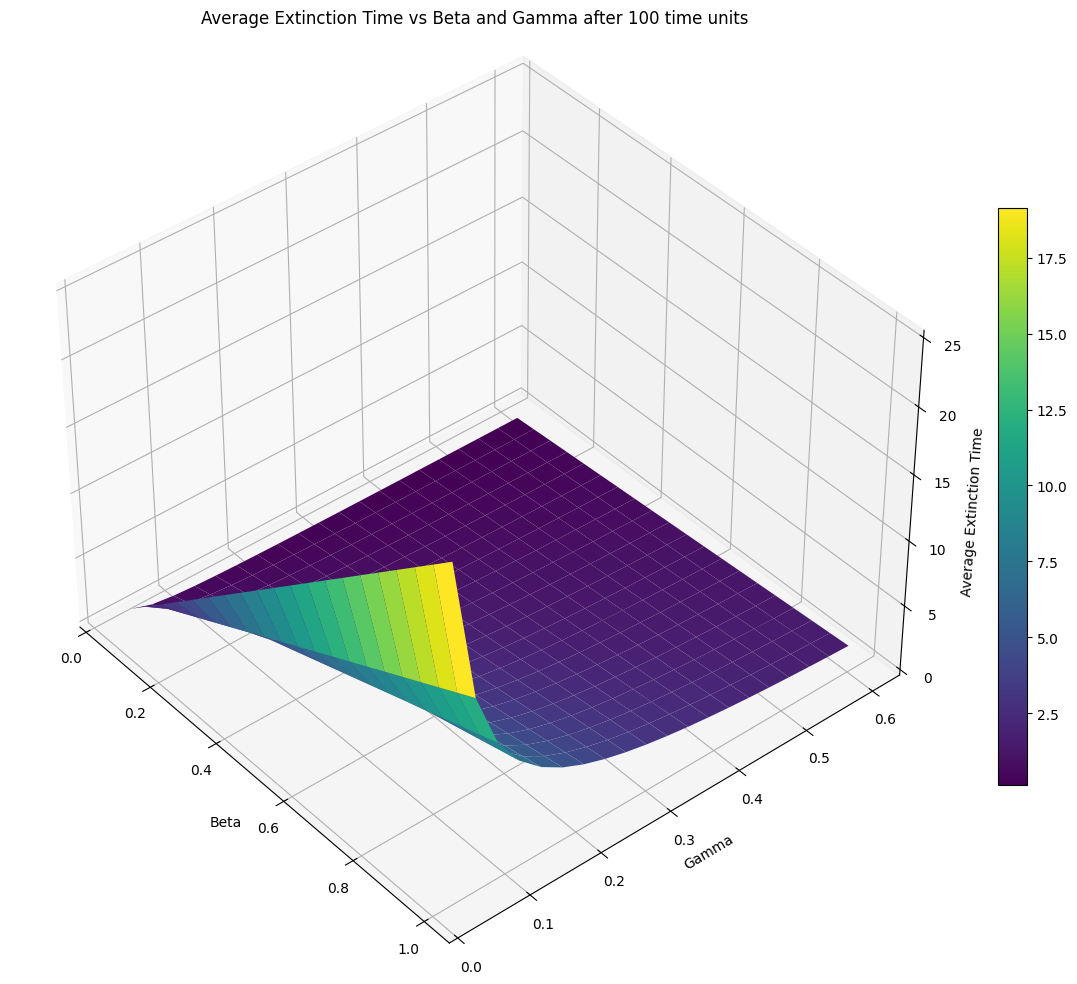

In [212]:
plot3DMeshBetaGamma(beta3DValues, 
                    gamma3DValues,
                    r0Values, 
                    "Beta", 
                    "Gamma", 
                    "Average Extinction Time", "Average Extinction Time vs Beta and Gamma after 100 time units", 
                    40, 320)

## Critical Community Size

In [60]:
X0 = 999
Y0 = 1
Z0 = 0
N = X0 + Y0 + Z0
beta = 0.5
gamma = 0.1
mu = 0.01

time = 100
timeInterval = 1

In [61]:
numRuns = 50

maxPopulation = 1000
populationSteps = 50
populationMin = maxPopulation / populationSteps
populationRange = np.linspace(populationMin, maxPopulation, populationSteps)

betaExtinctionMax = 1
betaExtinctionSteps = 20
betaExtinctionMin = betaExtinctionMax / betaExtinctionSteps
betaExtinctionRange = np.linspace(betaExtinctionMin, betaExtinctionMax, betaExtinctionSteps)

In [62]:
allModelsBetaPop = {}
variancesBetaPop = {}
meansBetaPop = {}
standardDeviationsBetaPop = {}
covarianceBetaPopSI = {}

for N in populationRange:
    for b in betaExtinctionRange:
        X0 = N - 1
        Y0 = 1
        Z0 = 0

        modelsBetaPop, totalMeans, totalVariances, totalStandardDeviations, covarianceSI = simulateNumGillespies(X0, Y0, Z0, 
                                                                                                                 N, 
                                                                                                                 b, 
                                                                                                                 gamma, mu, 
                                                                                                                 time, 
                                                                                                                 numRuns)

        meansBetaPop[N, b] = [i/numRuns for i in totalMeans]
        variancesBetaPop[N, b] = [i/numRuns for i in totalVariances]
        standardDeviationsBetaPop[N, b] = [i/numRuns for i in totalStandardDeviations]
        covarianceBetaPopSI[N, b] = covarianceSI / numRuns

        allModelsBetaPop[N, b] = modelsBetaPop

In [63]:
averageExtinctionTimePerBetaPop = {}
proportionExtinctionsPerBetaPop = {}

numExtinctionsBetaPop = 0

averageExtinctionTimePerBetaPop, proportionExtinctionsPerBetaPop = calcExtinctionMetrics3D(populationRange, 
                                                                                           betaExtinctionRange, 
                                                                                           allModelsBetaPop, 
                                                                                           time)

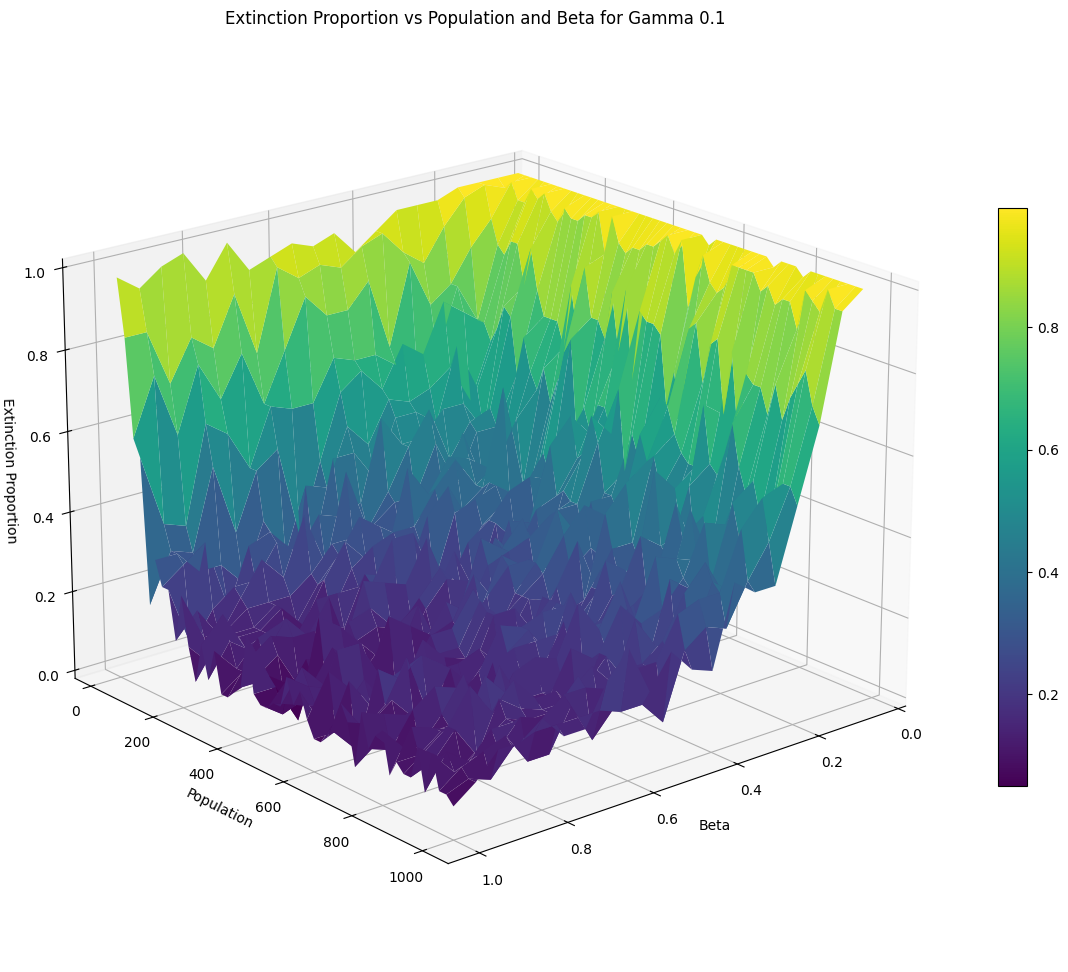

In [213]:
extinctionProportionPerBetaPopArray = [proportionExtinctionsPerBetaPop[N, b] for N in populationRange for b in betaExtinctionRange]

plot3DMeshBetaGamma(betaExtinctionRange, 
                    populationRange, 
                    extinctionProportionPerBetaPopArray, 
                    "Beta", 
                    "Population", 
                    "Extinction Proportion", 
                    "Extinction Proportion vs Population and Beta for Gamma 0.1", 
                    20, 50)

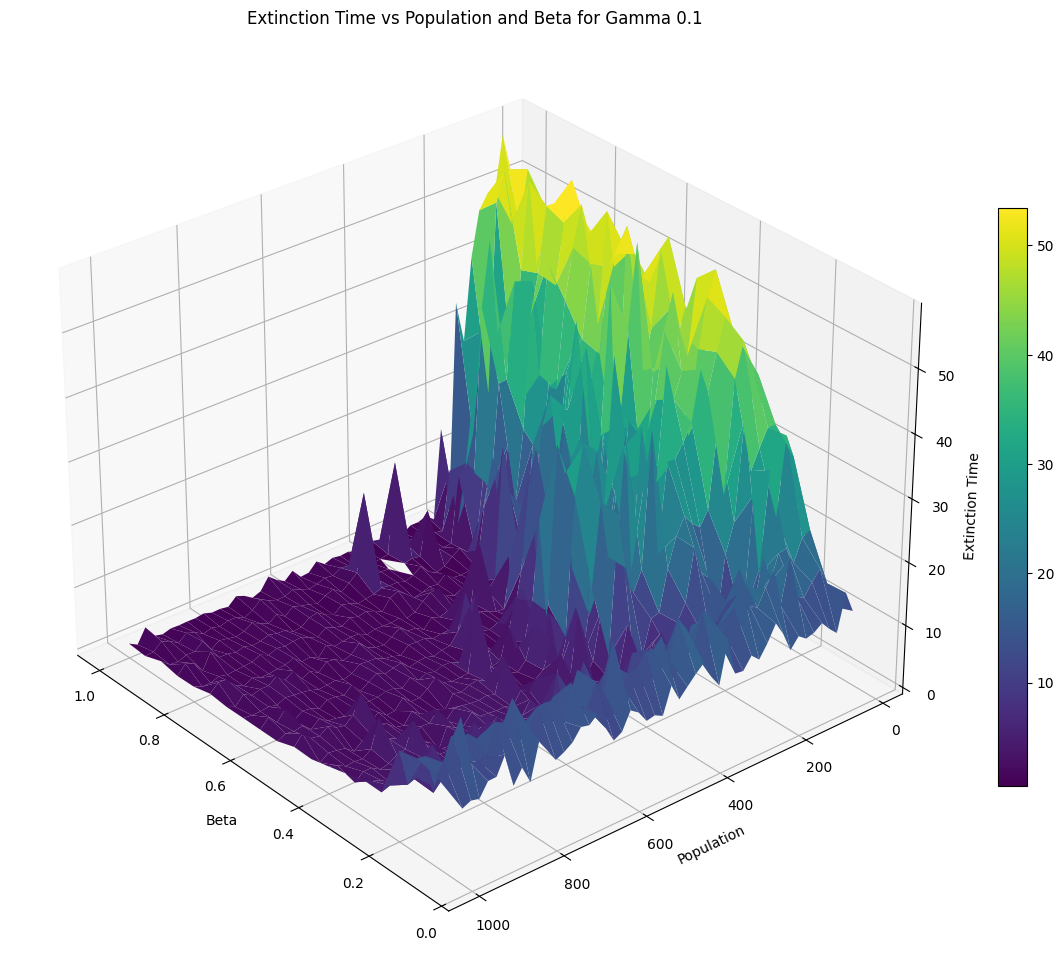

In [214]:
averageExtinctionTimePerBetaPopArray = [averageExtinctionTimePerBetaPop[N, b] for N in populationRange for b in betaExtinctionRange]

plot3DMeshBetaGamma(betaExtinctionRange,
                    populationRange, 
                    averageExtinctionTimePerBetaPopArray, 
                    "Beta", 
                    "Population", 
                    "Extinction Time", 
                    "Extinction Time vs Population and Beta for Gamma 0.1", 
                    30, 
                    140)